# Throughputs_LSSTComCam_c26202

Based on Lynne Jones code here: https://rubin-obs.slack.com/archives/C0824CTA335/p1732311332938929

Created:  2024.11.27

## 1. Initial Setup...

### 1.1 Import useful python packages

In [1]:
# Generic python packages
import pylab as plt
import numpy as np
import pandas as pd
import glob
import math
import os
import gc
import warnings

# LSST Science Pipelines (Stack) packages
import lsst.daf.butler as dafButler
import lsst.afw.display as afwDisplay

# rubin_sim-related packages
import rubin_sim.phot_utils as pt
import syseng_throughputs as st
from rubin_sim.data import get_data_dir

# Astropy-related packages
from astropy import units as u
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table

# Set a standard figure size to use
plt.rcParams['figure.figsize'] = (8.0, 8.0)
afwDisplay.setDefaultBackend('matplotlib')

# Set filter warnings to "ignore" to avoid a lot of "logorrhea" to the screen:
warnings.filterwarnings("ignore")

### 1.2 Include user input

In [2]:
# Which repo, collection, instrument, and skymap to use.
# See https://rubinobs.atlassian.net/wiki/spaces/DM/pages/48834013/Campaigns#1.1.-ComCam
# and https://rubinobs.atlassian.net/wiki/spaces/DM/pages/226656354/LSSTComCam+Intermittent+Cumulative+DRP+Runs
repo = 'embargo'
#collections = 'LSSTComCam/runs/DRP/20241101_20241113/w_2024_46/DM-47566'
#collections = 'LSSTComCam/runs/DRP/20241101_20241120/w_2024_47/DM-47746'
collections = 'LSSTComCam/runs/DRP/20241101_20241204/w_2024_49/DM-47988'
instrument = 'LSSTComCam'
skymap_name = 'lsst_cells_v1'
day_obs_start = 20241101
day_obs_end = 20241204

# Set environment variable to point to location of the rubin_sim_data 
#  (per Lynne Jones' Slack message on the #sciunit-photo-calib channel from 26 Nov 2024):
os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

# Which CalSpec C26202 spectrum FITS file to to use?
sedfile = '~/Downloads/c26202_stiswfcnic_007.fits'
#sedfile = '~/Downloads/c26202_mod_007.fits'
#sedfile = '~/Downloads/c26202_stiswfcnic_006.fits'
#sedfile = '~/Downloads/c26202_mod_008.fits'
#sedfile = '~/Downloads/c26202_stiswfcnic_007.fits'

# RA, DEC of C26202
raDeg = 53.136845833333325
decDeg = -27.86349444444444

# Plot symbol colors to use for ugrizy
plot_filter_colors_white_background = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00', 'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}

### 1.3 Define useful classes and functions

In [3]:
# Cartesian x,y match with error (per Claude-3.5-Sonnet)

def cartesianXYMatchWithError(df1, xcol1, ycol1, df2, xcol2, ycol2, sep_limit=1.0, allMatches=True):
    
    import numpy as np
    from scipy.spatial import cKDTree
    import pandas as pd

    # Create KD-tree for efficient spatial searching
    tree = cKDTree(df2[[xcol2, ycol2]])

    # Find nearest neighbors within sep_limit
    separations, indices = tree.query(df1[[xcol1, ycol1]],
                                  distance_upper_bound=sep_limit)

    # Create mask for valid matches (separations less than sep_limit)
    valid_matches = separations < sep_limit

    # Create merged dataframe using only valid matches
    merged_df = pd.concat([
        df1[valid_matches].reset_index(drop=True),
        df2.iloc[indices[valid_matches]].reset_index(drop=True)
        ], axis=1)

    # If you want to keep track of the match separations
    merged_df['separation'] = separations[valid_matches]

    # If you want to keep just the best match, sort by separation 
    # and keep first occurrence of each df2 index
    if allMatches != True:
        merged_df = merged_df.sort_values('separation').drop_duplicates(
            subset=df2.columns, keep='first'
        )

    return merged_df



In [4]:
# Useful class to stop "Run All" at a cell 
#  containing the command "raise StopExecution"
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

### 1.4 Instantiate the butler and registry

In [5]:
butler = dafButler.Butler(repo, collections=collections)
registry = butler.registry

## 2. Estimate expected counts for airmasses X=1.0 to 2.5

### 2.1 Build the hardware and system for ugrizy for Cerro Pachon for airmasses X=1.0-2.5 in steps of 0.1 airmass

In [6]:
# From https://github.com/lsst-pst/syseng_throughputs/blob/main/notebooks/InterpolateZeropoint.ipynb

defaultDirs = st.setDefaultDirs()
defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')
print(defaultDirs)

airmasses = np.arange(1.0, 2.6, 0.1).round(2)

system = {}
for x in airmasses:
    atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    h, s = st.buildHardwareAndSystem(defaultDirs, addLosses=True,  atmosphereOverride=atmos)
    system[x] = s
hardware = h


{'detector': '/home/d/dltucker/WORK/GitHub/syseng_throughputs/components/camera/detector/itl', 'lens1': '/home/d/dltucker/WORK/GitHub/syseng_throughputs/components/camera/lens1', 'lens2': '/home/d/dltucker/WORK/GitHub/syseng_throughputs/components/camera/lens2', 'lens3': '/home/d/dltucker/WORK/GitHub/syseng_throughputs/components/camera/lens3', 'filters': '/home/d/dltucker/WORK/GitHub/syseng_throughputs/components/camera/filters', 'mirror1': '/home/d/dltucker/WORK/GitHub/syseng_throughputs/components/telescope/mirror1', 'mirror2': '/home/d/dltucker/WORK/GitHub/syseng_throughputs/components/telescope/mirror2', 'mirror3': '/home/d/dltucker/WORK/GitHub/syseng_throughputs/components/telescope/mirror3', 'atmosphere': '/home/d/dltucker/WORK/GitHub/syseng_throughputs/siteProperties'}


### 2.2 Plot filter passbands (without the atmospheric component) and the atmospheric transmission for airmasses 1

Text(0.5, 0, 'Wavelength (nm)')

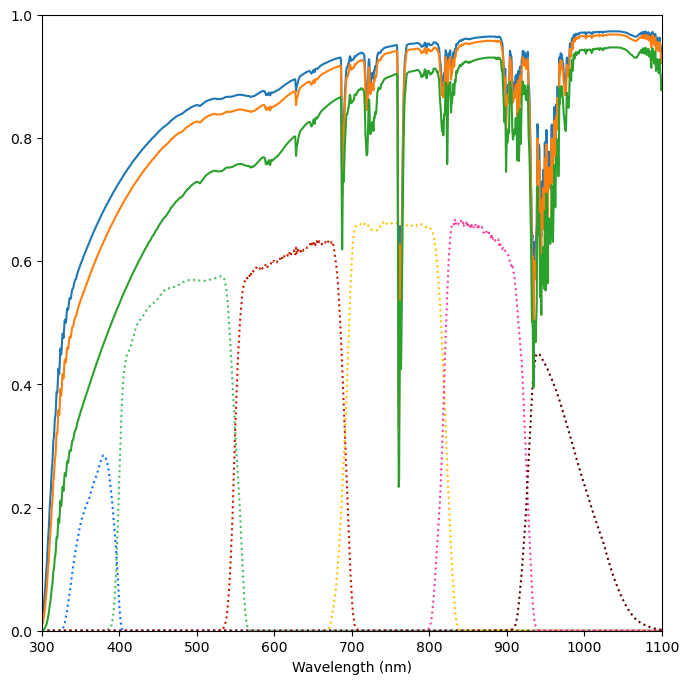

In [7]:
# From https://github.com/lsst-pst/syseng_throughputs/blob/main/notebooks/InterpolateZeropoint.ipynb

colors = plot_filter_colors_white_background
for f in 'ugrizy':
    plt.plot(hardware[f].wavelen, hardware[f].sb, color=colors[f], linestyle=':')
for x in [1.0, 1.2, 2.0]:
    atmos = st.readAtmosphere(os.path.join(get_data_dir(), 'throughputs', 'atmos'), atmosFile=f'atmos_{x*10 :.0f}_aerosol.dat')
    plt.plot(atmos.wavelen, atmos.sb, linestyle='-')
plt.ylim(0, 1)
plt.xlim(300, 1100)
plt.xlabel("Wavelength (nm)")


### 2.3 Read in the CalSpec SED file and translate it into `rubin_sim` format 

In [8]:
# Read the sedfile file 
seddata = fits.getdata(sedfile)

# Translate to rubin_sim format
wavelen = seddata['WAVELENGTH'] * u.angstrom.to(u.nanometer) # This is in angstroms - need in nanometers
flambda = seddata['FLUX'] / (u.angstrom.to(u.nanometer)) # this is in erg/sec/cm^^2/ang but we want /nm 

# Convert to rubin_sim format
sed = pt.Sed(wavelen=wavelen, flambda=flambda)

### 2.4 Define the photometric parameters to use.

In [9]:
phot_params = pt.PhotometricParameters(exptime=30, nexp=1, gain=1.0)


### 2.5 Calculate the expected counts for C26202 for the given photometric parameters over the airmass range of X=1.0-2.5

In [10]:
counts = {}
for f in 'ugrizy':
    counts[f] = []
    for x in airmasses:
        counts[f].append(sed.calc_adu(system[x][f], phot_params))
    counts[f] = np.array(counts[f])


In [11]:
df_counts = pd.DataFrame(counts, index=airmasses)
df_counts

,u,g,r,i,z,y
1.0,113908.522345,1.595930e+06,1.890461e+06,1.744184e+06,1.255182e+06,539006.979786
1.1,109281.294647,1.566493e+06,1.869165e+06,1.731674e+06,1.248109e+06,533419.595109
1.2,104813.058291,1.537443e+06,1.848017e+06,1.719315e+06,1.241127e+06,528033.910791
1.3,100596.180751,1.509330e+06,1.827383e+06,1.707302e+06,1.234321e+06,522927.767380
1.4,96529.060417,1.481619e+06,1.806914e+06,1.695422e+06,1.227598e+06,517979.924119
1.5,92610.700878,1.454323e+06,1.786599e+06,1.683676e+06,1.220949e+06,513176.616890
1.6,88908.469079,1.427891e+06,1.766780e+06,1.672205e+06,1.214450e+06,508594.349407
1.7,85277.586959,1.401428e+06,1.746830e+06,1.660723e+06,1.207942e+06,504057.394586
1.8,81828.423146,1.375694e+06,1.727274e+06,1.649446e+06,1.201556e+06,499686.042699
1.9,78680.372806,1.351518e+06,1.708706e+06,1.638680e+06,1.195429e+06,495613.639668


### 2.6 Output results to CSV file

In [12]:
outputFile = 'LSSTComCam_C26202_expected_counts.csv'
df_counts.to_csv(outputFile)  #  Here, we want to keep the index for the DataFrame, which, in this case, is the airmass

## 3. Query USDF Butler for ComCam exposures

### 3.1 Create query

In [13]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Query the metadata for the `exposure` dimension, limiting the results to this particular instrument and range of days of observation:
query="instrument='%s' AND day_obs>=%d AND day_obs<=%d" % (instrument, day_obs_start, day_obs_end)
results = registry.queryDimensionRecords('exposure',where=query)


### 3.2 Check that there are results

In [14]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Stop executing if there are no results returned:

n_results = results.count()

if n_results <= 0:
    raise StopExecution
else:
    print("""There are %d results returned from querying the butler for instrument %s between dates %d and %d (inclusive).""" % 
          (n_results, instrument, day_obs_start, day_obs_end))

There are 10918 results returned from querying the butler for instrument LSSTComCam between dates 20241101 and 20241204 (inclusive).


### 3.3 Instantiate a DataFrame to contain the exposure information

In [15]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Instantiate a pandas `DataFrame` with useful columns available in the `exposure` dimension:
df_exp = pd.DataFrame(columns=['id', 'obs_id','day_obs', 'seq_num',
                                    'time_start','time_end' ,'type', 'reason', 
                                    'target','filter','zenith_angle',
                                    'expos','ra','dec','skyangle',
                                    'azimuth','zenith','science_program',
                                    'jd','mjd'])

### 3.4 Read the query results into the new Data Frame

In [16]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Read the query results into the new pandas `DataFrame`:

for count, info in enumerate(results):
    
    try:

        df_exp.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  info.timespan.begin.utc.iso,
                                  info.timespan.end.utc.iso, 
                                  info.observation_type, info.observation_reason, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info.timespan.begin.jd, info.timespan.begin.mjd]

    except:
    
        print(">>>   Unexpected error:", sys.exc_info()[0])
        info_timespan_begin_to_string = "2021-01-01 00:00:00.00"
        info_timespan_end_to_string = "2051-01-01 00:00:00.00"
        info_timespan_begin_jd = 0
        info_timespan_begin_mjd = 0
        df_exp.loc[count] = [info.id, info.obs_id, info.day_obs, info.seq_num, 
                                  pd.to_datetime(info_timespan_begin_to_string),
                                  pd.to_datetime(info_timespan_end_to_string), 
                                  info.observation_type, info.observation_reason, info.target_name, 
                                  info.physical_filter, info.zenith_angle, 
                                  info.exposure_time,info.tracking_ra, info.tracking_dec, 
                                  info.sky_angle,info.azimuth ,info.zenith_angle, 
                                  info.science_program, info_timespan_begin_jd, info_timespan_begin_mjd ]
 
    

### 3.5 Clean up DataFrame

In [17]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Re-cast the `id`, `day_obs`, and `seq_num` rows as `int`'s:
df_exp = df_exp.astype({"id": int,'day_obs': int,'seq_num':int})

In [18]:
# Taken from vv-team-notebooks/reports/TargetReport.ipynb

# Replace `NaN`'s in the `ra` and `dec` columns with zero.  
# (`NaN`'s in `ra`, `dec` wreak havoc for the healpix tools defined in Section 1.2 above.) 
# ***(Maybe no longer necessary?)***

df_exp['ra'] = df_exp['ra'].fillna(0)
df_exp['dec'] = df_exp['dec'].fillna(0)

### 3.6 Add airmass to DataFrame

In [19]:
# Add an airmass to df_exp...

df_exp['airmass'] = np.round(1./np.cos(np.deg2rad(df_exp['zenith_angle'])), decimals=3)

In [20]:
df_exp[['zenith_angle','airmass']]

,zenith_angle,airmass
0,3.603761,1.002
1,3.603761,1.002
2,3.603761,1.002
3,3.603761,1.002
4,2.272500,1.001
...,...,...
10913,0.000667,1.000
10914,0.000667,1.000
10915,0.000667,1.000
10916,0.000667,1.000


### 3.7 Extract just "science" exposures

In [21]:
# Create a `DataFrame` containing just the science exposures:
df_sci = df_exp[df_exp.type == 'science']

In [22]:
# Look at columns for the (exposure/visit) id, zenith_angle, and airmass:
df_sci[['id', 'zenith_angle','airmass']]

,id,zenith_angle,airmass
897,2024110500210,25.543732,1.108
911,2024110500206,25.293112,1.106
912,2024110500207,25.355606,1.107
913,2024110500208,25.418120,1.107
914,2024110500209,25.481003,1.108
...,...,...,...
10656,2024120300170,19.826073,1.063
10657,2024120300171,19.919844,1.064
10658,2024120300172,19.894167,1.063
10659,2024120300173,20.173809,1.065


### 3.8 Remove any exposures in the "bad visit" list

#### 3.8.1 Read in "bad visit" list

In [23]:
df_bad_visits=Table.read("https://raw.githubusercontent.com/lsst-dm/excluded_visits/refs/heads/main/LSSTComCam/bad.ecsv").to_pandas()
#df_bad_visits.rename(columns={'exposure': 'visit'}, inplace=True)
df_bad_visits

,exposure,comment
0,2024110500234,donuts
1,2024110500236,donuts
2,2024110500237,donuts
3,2024110500240,donuts
4,2024110500241,donuts
...,...,...
82,2024120900448,donuts
83,2024120900449,donuts
84,2024120900450,donuts
85,2024120900451,donuts + slew during exposure


#### 3.8.2 Remove from df_sci and exposuress found in df_bad_visits

In [24]:
df_sci = df_sci[~df_sci['id'].isin(df_bad_visits['exposure'])]


In [25]:
# Look at columns for the (exposure/visit) id, zenith_angle, and airmass:
df_sci[['id', 'zenith_angle','airmass']]

,id,zenith_angle,airmass
897,2024110500210,25.543732,1.108
911,2024110500206,25.293112,1.106
912,2024110500207,25.355606,1.107
913,2024110500208,25.418120,1.107
914,2024110500209,25.481003,1.108
...,...,...,...
10656,2024120300170,19.826073,1.063
10657,2024120300171,19.919844,1.064
10658,2024120300172,19.894167,1.063
10659,2024120300173,20.173809,1.065


### 3.9 Save results as a CSV file

In [26]:
outputFile = """LSSTComCam_visits_%d-%d.csv""" % (day_obs_start, day_obs_end)
df_sci.to_csv(outputFile, index=False)

### 3.10 Create a Pandas DataFrame from df_sci that just contains the visit id, zenith angle, and airmass

In [27]:
df_sci_airmass = df_sci[['id', 'zenith_angle','airmass']].copy(deep=True)
df_sci_airmass.reset_index(drop=True, inplace=True)
df_sci_airmass

,id,zenith_angle,airmass
0,2024110500210,25.543732,1.108
1,2024110500206,25.293112,1.106
2,2024110500207,25.355606,1.107
3,2024110500208,25.418120,1.107
4,2024110500209,25.481003,1.108
...,...,...,...
1253,2024120300170,19.826073,1.063
1254,2024120300171,19.919844,1.064
1255,2024120300172,19.894167,1.063
1256,2024120300173,20.173809,1.065


## 4. Query USDF Butler for ComCam measurements of C26202

### 4.1 Find the `dataId`'s for all `calexp`'s in this repo/collection that overlap the sky position of C26202:

In [28]:
datasetRefs = butler.query_datasets("calexp", where="visit_detector_region.region OVERLAPS POINT(ra, dec)",
                                    bind={"ra": raDeg, "dec": decDeg})

for i, ref in enumerate(datasetRefs):    
    print(i, ref.dataId)

print(f"\nFound {len(datasetRefs)} calexps")

0 {instrument: 'LSSTComCam', detector: 0, visit: 2024111000112, band: 'i', day_obs: 20241110, physical_filter: 'i_06'}
1 {instrument: 'LSSTComCam', detector: 0, visit: 2024111100074, band: 'i', day_obs: 20241111, physical_filter: 'i_06'}
2 {instrument: 'LSSTComCam', detector: 0, visit: 2024111100075, band: 'r', day_obs: 20241111, physical_filter: 'r_03'}
3 {instrument: 'LSSTComCam', detector: 0, visit: 2024111100087, band: 'r', day_obs: 20241111, physical_filter: 'r_03'}
4 {instrument: 'LSSTComCam', detector: 0, visit: 2024111100088, band: 'i', day_obs: 20241111, physical_filter: 'i_06'}
5 {instrument: 'LSSTComCam', detector: 0, visit: 2024111100093, band: 'i', day_obs: 20241111, physical_filter: 'i_06'}
6 {instrument: 'LSSTComCam', detector: 0, visit: 2024111100094, band: 'r', day_obs: 20241111, physical_filter: 'r_03'}
7 {instrument: 'LSSTComCam', detector: 0, visit: 2024111500238, band: 'r', day_obs: 20241115, physical_filter: 'r_03'}
8 {instrument: 'LSSTComCam', detector: 0, visit:

### 4.2 Create a pandas Dataframe containing the `sourceTable` info for all these `calexp`'s

#### 4.2.1 Loop over the `datasetRefs` again, grabbing the contents of the `sourceTable` table for each `ref` and combining them into all into one big pandas DataFrame.  

In [29]:
src_list = []

for i, ref in enumerate(datasetRefs):
    
    # Retrieve sourceTable for this visit & detector...
    dataId = {'visit': ref.dataId['visit'], 'detector': ref.dataId['detector']}
    src = butler.get('sourceTable', dataId=dataId)
    src_list.append(src)
    print(f"{i} Visit {ref.dataId['visit']}, Detector {ref.dataId['detector']}:  Retrieved catalog of {len(src)} sources.")

src_all = pd.concat(src_list, ignore_index=True)

print("")
print(f"Total combined catalog contains {len(src_all)} sources.")


0 Visit 2024111000112, Detector 0:  Retrieved catalog of 1006 sources.
1 Visit 2024111100074, Detector 0:  Retrieved catalog of 1562 sources.
2 Visit 2024111100075, Detector 0:  Retrieved catalog of 1204 sources.
3 Visit 2024111100087, Detector 0:  Retrieved catalog of 1488 sources.
4 Visit 2024111100088, Detector 0:  Retrieved catalog of 1973 sources.
5 Visit 2024111100093, Detector 0:  Retrieved catalog of 1854 sources.
6 Visit 2024111100094, Detector 0:  Retrieved catalog of 1489 sources.
7 Visit 2024111500238, Detector 0:  Retrieved catalog of 1406 sources.
8 Visit 2024111500286, Detector 0:  Retrieved catalog of 1167 sources.
9 Visit 2024111500287, Detector 0:  Retrieved catalog of 1847 sources.
10 Visit 2024111600115, Detector 0:  Retrieved catalog of 1539 sources.
11 Visit 2024111700126, Detector 0:  Retrieved catalog of 2393 sources.
12 Visit 2024111700127, Detector 0:  Retrieved catalog of 2422 sources.
13 Visit 2024111700128, Detector 0:  Retrieved catalog of 2517 sources.
14

In [30]:
src_all

,coord_ra,coord_dec,visit,detector,parentSourceId,x,y,xErr,yErr,ra,...,iDebiasedPSF_flag_edge,hsmShapeRegauss_flag,hsmShapeRegauss_flag_galsim,hsmShapeRegauss_flag_no_pixels,hsmShapeRegauss_flag_not_contained,hsmShapeRegauss_flag_parent_source,sky_source,detect_isPrimary,band,physical_filter
0,53.190168,-27.735114,2024111000112,0,0,736.000000,17.000000,NaN,NaN,53.190168,...,True,False,False,False,False,False,False,True,i,i_06
1,53.221834,-27.809401,2024111000112,0,0,2162.000000,15.000000,NaN,NaN,53.221834,...,True,False,False,False,False,False,False,True,i,i_06
2,53.239591,-27.851079,2024111000112,0,0,2962.211673,14.385582,0.255396,0.496841,53.239591,...,True,False,False,False,False,False,False,True,i,i_06
3,53.262796,-27.908386,2024111000112,0,0,4056.000000,32.000000,NaN,NaN,53.262796,...,True,False,False,False,False,False,False,True,i,i_06
4,53.200978,-27.765021,2024111000112,0,0,1299.147713,44.899586,1.583083,1.048285,53.200978,...,False,True,False,False,False,False,False,False,i,i_06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358219,53.305424,-27.919816,2024120300170,8,191755010453801261,2572.301756,3985.305110,0.725522,0.453763,53.305424,...,True,True,False,False,False,False,False,True,r,r_03
1358220,53.322323,-28.030237,2024120300170,8,191755010453801262,570.876013,3965.232369,0.155732,0.100224,53.322323,...,False,False,False,False,False,False,False,True,r,r_03
1358221,53.323749,-28.030771,2024120300170,8,191755010453801262,558.108369,3986.221634,0.397867,0.383604,53.323749,...,True,False,False,False,False,False,False,True,r,r_03
1358222,53.326865,-28.048204,2024120300170,8,191755010453801267,241.000000,3990.000000,NaN,NaN,53.326865,...,True,False,False,False,False,False,False,True,r,r_03


#### 4.2.2 Add zenith distance and airmass to src_all

In [31]:
src_all_tmp = pd.merge(src_all, df_sci_airmass, left_on='visit', right_on='id')
src_all_tmp.drop('id', axis=1, inplace=True)
# Remove any rows for which airmass is a NaN
src_all_tmp.dropna(subset=['airmass'], inplace=True)
src_all = src_all_tmp
src_all

,coord_ra,coord_dec,visit,detector,parentSourceId,x,y,xErr,yErr,ra,...,hsmShapeRegauss_flag_galsim,hsmShapeRegauss_flag_no_pixels,hsmShapeRegauss_flag_not_contained,hsmShapeRegauss_flag_parent_source,sky_source,detect_isPrimary,band,physical_filter,zenith_angle,airmass
0,53.190168,-27.735114,2024111000112,0,0,736.000000,17.000000,NaN,NaN,53.190168,...,False,False,False,False,False,True,i,i_06,58.652511,1.922
1,53.221834,-27.809401,2024111000112,0,0,2162.000000,15.000000,NaN,NaN,53.221834,...,False,False,False,False,False,True,i,i_06,58.652511,1.922
2,53.239591,-27.851079,2024111000112,0,0,2962.211673,14.385582,0.255396,0.496841,53.239591,...,False,False,False,False,False,True,i,i_06,58.652511,1.922
3,53.262796,-27.908386,2024111000112,0,0,4056.000000,32.000000,NaN,NaN,53.262796,...,False,False,False,False,False,True,i,i_06,58.652511,1.922
4,53.200978,-27.765021,2024111000112,0,0,1299.147713,44.899586,1.583083,1.048285,53.200978,...,False,False,False,False,False,False,i,i_06,58.652511,1.922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1358219,53.305424,-27.919816,2024120300170,8,191755010453801261,2572.301756,3985.305110,0.725522,0.453763,53.305424,...,False,False,False,False,False,True,r,r_03,19.826073,1.063
1358220,53.322323,-28.030237,2024120300170,8,191755010453801262,570.876013,3965.232369,0.155732,0.100224,53.322323,...,False,False,False,False,False,True,r,r_03,19.826073,1.063
1358221,53.323749,-28.030771,2024120300170,8,191755010453801262,558.108369,3986.221634,0.397867,0.383604,53.323749,...,False,False,False,False,False,True,r,r_03,19.826073,1.063
1358222,53.326865,-28.048204,2024120300170,8,191755010453801267,241.000000,3990.000000,NaN,NaN,53.326865,...,False,False,False,False,False,True,r,r_03,19.826073,1.063


#### 4.2.3 Save `src_all` as a CSV file

In [32]:
src_all.to_csv('LSSTComCam_C26202_fields.sourceTable.csv', index=False)

### 4.3 Create a pandas Dataframe containing the `icSrc` table info for all these `calexp`'s

#### 4.3.1 Loop over the `datasetRefs` again, grabbing the contents of the `icSrc` table for each `ref` and combining them into all into one big pandas DataFrame.  

In [33]:
icSrc_list = []

for i, ref in enumerate(datasetRefs):
    
    # Retrieve sourceTable for this visit & detector...
    dataId = {'visit': ref.dataId['visit'], 'detector': ref.dataId['detector']}
    icSrc = butler.get('icSrc', dataId=dataId)
    icSrc_table = icSrc.asAstropy()
    df_icSrc = icSrc_table.to_pandas()
    icSrc_list.append(df_icSrc)
    print(f"{i} Visit {ref.dataId['visit']}, Detector {ref.dataId['detector']}:  Retrieved catalog of {len(icSrc_table)} sources.")

icSrc_all = pd.concat(icSrc_list, ignore_index=True)

print("")
print(f"Total combined catalog contains {len(icSrc_all)} sources.")


0 Visit 2024111000112, Detector 0:  Retrieved catalog of 115 sources.
1 Visit 2024111100074, Detector 0:  Retrieved catalog of 161 sources.
2 Visit 2024111100075, Detector 0:  Retrieved catalog of 127 sources.
3 Visit 2024111100087, Detector 0:  Retrieved catalog of 152 sources.
4 Visit 2024111100088, Detector 0:  Retrieved catalog of 199 sources.
5 Visit 2024111100093, Detector 0:  Retrieved catalog of 212 sources.
6 Visit 2024111100094, Detector 0:  Retrieved catalog of 174 sources.
7 Visit 2024111500238, Detector 0:  Retrieved catalog of 140 sources.
8 Visit 2024111500286, Detector 0:  Retrieved catalog of 129 sources.
9 Visit 2024111500287, Detector 0:  Retrieved catalog of 183 sources.
10 Visit 2024111600115, Detector 0:  Retrieved catalog of 152 sources.
11 Visit 2024111700126, Detector 0:  Retrieved catalog of 211 sources.
12 Visit 2024111700127, Detector 0:  Retrieved catalog of 192 sources.
13 Visit 2024111700128, Detector 0:  Retrieved catalog of 230 sources.
14 Visit 2024111

In [34]:
icSrc_all

,id,coord_ra,coord_dec,parent,calib_psf_candidate,calib_psf_used,calib_psf_reserved,base_SdssCentroid_x,slot_Centroid_x,base_SdssCentroid_y,...,base_PsfFlux_apCorrErr,slot_PsfFlux_apCorrErr,base_PsfFlux_flag_apCorr,slot_PsfFlux_flag_apCorr,base_ClassificationExtendedness_value,base_ClassificationExtendedness_flag,base_FootprintArea_value,coord_raErr,coord_decErr,coord_ra_dec_Cov
0,190945707585175553,NaN,NaN,0,False,False,False,2962.000000,2962.000000,15.000000,...,0.0,0.0,False,False,NaN,True,1853,NaN,NaN,NaN
1,190945707585175554,NaN,NaN,0,False,False,False,4056.000000,4056.000000,32.000000,...,0.0,0.0,False,False,NaN,True,1908,NaN,NaN,NaN
2,190945707585175555,NaN,NaN,0,False,False,False,717.002053,717.002053,69.379874,...,0.0,0.0,False,False,1.0,False,2756,NaN,NaN,NaN
3,190945707585175556,NaN,NaN,0,False,False,False,1459.985430,1459.985430,76.159530,...,0.0,0.0,False,False,1.0,False,3483,NaN,NaN,NaN
4,190945707585175557,NaN,NaN,0,True,True,False,2635.630582,2635.630582,92.022267,...,0.0,0.0,False,False,0.0,False,2553,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117238,191755010453799195,NaN,NaN,0,False,False,False,3925.535060,3925.535060,3963.776130,...,0.0,0.0,False,False,NaN,True,711,NaN,NaN,NaN
117239,191755010453799196,NaN,NaN,0,False,False,False,570.876143,570.876143,3965.233039,...,0.0,0.0,False,False,1.0,False,718,NaN,NaN,NaN
117240,191755010453799197,NaN,NaN,0,False,False,False,1247.205895,1247.205895,3970.922699,...,0.0,0.0,False,False,1.0,False,567,NaN,NaN,NaN
117241,191755010453799198,NaN,NaN,0,False,False,False,2855.000000,2855.000000,3979.000000,...,0.0,0.0,False,False,NaN,True,1007,NaN,NaN,NaN


#### 4.3.2 Save `icSrc_all` as a CSV file

In [35]:
icSrc_all.to_csv('LSSTComCam_C26202_fields_icSrc.csv', index=False)

## 5 Calculate psf to total flux aperture magnitudes on a per-visit basis

### 5.1 Match src_all and icSrc_all catalogs

In [36]:
# We will perform the match using the cartesianXYMatchWithError function defined above.

df1 = src_all.copy(deep=True)
xcol1 = 'x'
ycol1 = 'y'

df2 = icSrc_all.copy(deep=True)
xcol2 = 'base_SdssCentroid_x'
ycol2 = 'base_SdssCentroid_y'

sep_limit = 1.0

df_match = cartesianXYMatchWithError(df1, xcol1, ycol1, df2, xcol2, ycol2, 1.0, False)

# Print number of matches
print(f"Number of matches found: {len(df_match)}")

# Print statistics of match distances
print("\nMatch distance statistics:")
print(df_match['separation'].describe())

Number of matches found: 168465

Match distance statistics:
count    168465.000000
mean          0.119796
std           0.267777
min           0.000000
25%           0.000005
50%           0.000040
75%           0.012012
max           0.999993
Name: separation, dtype: float64


In [37]:
df_match

,coord_ra,coord_dec,visit,detector,parentSourceId,x,y,xErr,yErr,ra,...,slot_PsfFlux_apCorrErr,base_PsfFlux_flag_apCorr,slot_PsfFlux_flag_apCorr,base_ClassificationExtendedness_value,base_ClassificationExtendedness_flag,base_FootprintArea_value,coord_raErr,coord_decErr,coord_ra_dec_Cov,separation
121636,52.999245,-27.821687,2024110800289,5,190875528914272257,20.000000,17.000000,1.653230,0.048689,52.999245,...,0.0,False,False,NaN,True,6847,NaN,NaN,NaN,0.000000
102186,53.127276,-27.986487,2024111200309,4,191016287873269903,1542.000000,388.000000,0.607140,0.165465,53.127276,...,0.0,False,False,NaN,True,1649,NaN,NaN,NaN,0.000000
80805,53.210548,-27.809276,2024112800132,3,191579047770194316,760.000000,732.000000,0.018030,0.019287,53.210548,...,0.0,False,False,NaN,True,7124,NaN,NaN,NaN,0.000000
65749,53.103087,-27.900037,2024120300153,2,0,2786.000000,1805.000000,0.041362,0.025901,53.103087,...,0.0,False,False,NaN,True,8010,NaN,NaN,NaN,0.000000
107578,53.191498,-27.962641,2024112800139,4,0,3263.000000,2541.000000,0.316167,0.265271,53.191498,...,0.0,False,False,NaN,True,5612,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106547,53.145952,-28.015352,2024112800112,4,0,2628.128467,1132.012678,2.173549,2.641488,53.145952,...,0.0,False,False,0.0,False,545,NaN,NaN,NaN,0.999905
82885,53.261811,-27.748169,2024112800142,3,191579058507613675,1950.000000,2596.000000,0.357772,0.421610,53.261811,...,0.0,False,False,0.0,False,559,NaN,NaN,NaN,0.999906
113730,53.100132,-27.751245,2024110800252,5,0,3164.579571,2206.157265,0.704950,1.532770,53.100132,...,0.0,False,False,0.0,False,307,NaN,NaN,NaN,0.999971
94592,53.278603,-27.908173,2024120100202,3,0,2940.564062,2290.101009,0.664542,0.428034,53.278603,...,0.0,False,False,1.0,False,1364,NaN,NaN,NaN,0.999982


### 5.2 Create dataframe containing the visit-by-visit median psf-to-total flux aperture corrections.

In [38]:
# Create a column containing the psf-to-total flux aperture correction for each individual source.
#  We will use 'base_PsfFlux_instFlux' as our primary instrumental flux measurement.
#  We will take 'base_CircularApertureFlux_70_0_instFlux' as the total flux.
df_match['apCorrTot'] = df_match['base_CircularApertureFlux_70_0_instFlux'] / df_match['base_PsfFlux_instFlux']

# Create a mask to cull sources with "bad" measurements.
mask1 = (~df_match.pixelFlags_bad) & (~df_match.pixelFlags_saturated) & \
        (~df_match.extendedness_flag) & (df_match.detect_isPrimary) & \
        (~df_match.base_CircularApertureFlux_70_0_flag) & \
        (~df_match.base_PsfFlux_flag)  

# Create an another mask to cull sources that are too faint or (possibly) too bright.
psfFlux_min = df_match[mask1]['base_PsfFlux_instFlux'].quantile(0.75)
psfFlux_max = df_match[mask1]['base_PsfFlux_instFlux'].quantile(0.95)
mask = mask1 & (df_match.base_PsfFlux_instFlux >= psfFlux_min) & (df_match.base_PsfFlux_instFlux < psfFlux_max)

# Calculate median ratio per visit, ignoring NaNs
median_apCorrTots = df_match[mask].groupby('visit')['apCorrTot'].agg(lambda x: np.nanmedian(x))

# Create a pandas DataFrame out of this pandas Series
df_median_apCorrTots = median_apCorrTots.reset_index()

# Rename `apCorrTot` to `apCorrTot_median` in df_median_apCorrTots
df_median_apCorrTots.rename(columns={'apCorrTot': 'apCorrTot_median'}, inplace=True)

## Remove the original apCorrTot column from df_match
#df_match.drop('apCorrTot', axis=1, inplace=True)

# Show the dataframe of median apCorrTots by visit id
df_median_apCorrTots

,visit,apCorrTot_median
0,2024110800245,1.052055
1,2024110800246,1.042043
2,2024110800247,1.042230
3,2024110800248,1.058561
4,2024110800249,1.053594
...,...,...
509,2024120300170,1.052653
510,2024120300171,1.060896
511,2024120300172,1.045835
512,2024120300173,1.039006


### 5.3 Add the visit-by-visit median aperture corrections to the `df_match` (combined `src_all`+`icSrc_all`) pandas DataFrame

In [39]:
df_match = df_match.merge(df_median_apCorrTots, on='visit')

In [40]:
# Display result sorted in ascending order of visit (primarily) and RA (secondarily)
df_match.sort_values(by=['visit', 'ra'])

,coord_ra,coord_dec,visit,detector,parentSourceId,x,y,xErr,yErr,ra,...,slot_PsfFlux_flag_apCorr,base_ClassificationExtendedness_value,base_ClassificationExtendedness_flag,base_FootprintArea_value,coord_raErr,coord_decErr,coord_ra_dec_Cov,separation,apCorrTot,apCorrTot_median
145177,52.976016,-27.814832,2024110800245,2,0,51.575948,42.609181,1.006203,4.597411,52.976016,...,False,NaN,True,1860,NaN,NaN,NaN,0.446574,NaN,1.052055
49597,52.978716,-27.799593,2024110800245,2,0,328.075406,22.994031,0.010904,0.012179,52.978716,...,False,0.0,False,533,NaN,NaN,NaN,0.000007,NaN,1.052055
52537,52.983712,-27.782326,2024110800245,2,0,648.282654,30.783793,0.013722,0.015460,52.983712,...,False,0.0,False,478,NaN,NaN,NaN,0.000008,NaN,1.052055
42862,52.992126,-27.785899,2024110800245,2,0,615.820304,175.467276,0.012965,0.014378,52.992126,...,False,0.0,False,512,NaN,NaN,NaN,0.000005,1.169673,1.052055
138219,52.995051,-27.776497,2024110800245,2,190875481657049180,790.898726,182.912399,0.013979,0.011398,52.995051,...,False,NaN,True,3031,NaN,NaN,NaN,0.133904,3.614096,1.052055
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75742,53.248671,-27.841830,2024120300174,5,0,1125.946138,3940.669033,0.040073,0.032488,53.248671,...,False,1.0,False,1014,NaN,NaN,NaN,0.000022,NaN,1.029906
100179,53.250768,-27.861282,2024120300174,5,0,775.808117,3913.495644,0.359658,0.425552,53.250768,...,False,NaN,True,3443,NaN,NaN,NaN,0.000170,6.837675,1.029906
98123,53.251755,-27.846147,2024120300174,5,0,1041.093448,3975.635682,0.297503,0.498220,53.251755,...,False,NaN,True,1417,NaN,NaN,NaN,0.000134,NaN,1.029906
163687,53.253841,-27.863446,2024120300174,5,0,729.092399,3954.928356,0.910711,0.631579,53.253841,...,False,NaN,True,983,NaN,NaN,NaN,0.910425,NaN,1.029906


## 6. Extract the rows containing C26202 from the matched src_all and icSrc_all catalogs

In [41]:
# Based on code retrieved from Claude-3.5-Sonnet

# Create a mask to cull sources with "bad" measurements.
mask1 = (~df_match.pixelFlags_bad) & (~df_match.pixelFlags_saturated) & \
        (~df_match.extendedness_flag) & (df_match.detect_isPrimary) & \
        (~df_match.base_CircularApertureFlux_70_0_flag) & \
        (~df_match.base_PsfFlux_flag)  

# Apply mask, keeping only the "good" measurements of `df_match`
df_match_cleaned = df_match[mask1]

# Create SkyCoord object for the coordinates of C26202
ref_coord = SkyCoord(ra=raDeg*u.degree, dec=decDeg*u.degree)

# Create SkyCoord object for all points in the dataframe
df_coords = SkyCoord(ra=df_match_cleaned['ra'].values*u.degree, 
                     dec=df_match_cleaned['dec'].values*u.degree)

# Calculate separations
separations = ref_coord.separation(df_coords)

# Create mask for points within 3.0 arcseconds
mask_sep = separations < 3.0*u.arcsec

# Get filtered dataframe
nearby_good_df = df_match_cleaned[mask_sep]

# If you want to include the separations in the result
orig_columns = nearby_good_df.columns
nearby_good_df = df_match_cleaned[mask_sep].copy()
nearby_good_df['separation_c26202'] = separations[mask_sep].arcsec

# Find (and keep) the closet match within the match radius
best_df = nearby_good_df.sort_values('separation_c26202').drop_duplicates(subset=orig_columns, keep='first')


In [42]:
# Display the resulting table...
best_df

,coord_ra,coord_dec,visit,detector,parentSourceId,x,y,xErr,yErr,ra,...,base_ClassificationExtendedness_value,base_ClassificationExtendedness_flag,base_FootprintArea_value,coord_raErr,coord_decErr,coord_ra_dec_Cov,separation,apCorrTot,apCorrTot_median,separation_c26202
8224,53.137017,-27.863442,2024112800119,3,0,3060.898364,3046.182395,0.004170,0.004297,53.137017,...,0.0,False,2299,NaN,NaN,NaN,7.597149e-07,1.055060,1.061664,0.578175
38184,53.137021,-27.863444,2024120100178,3,0,2440.241990,2381.297652,0.004533,0.004676,53.137021,...,0.0,False,2501,NaN,NaN,NaN,4.216190e-06,1.043875,1.053824,0.585298
6331,53.137019,-27.863438,2024112800132,3,0,838.291819,2251.086430,0.004137,0.003789,53.137019,...,0.0,False,2062,NaN,NaN,NaN,5.075391e-07,1.036518,1.051420,0.585646
33230,53.137020,-27.863442,2024112800137,3,191579053138904780,1912.424696,3292.856539,0.003800,0.003653,53.137020,...,0.0,False,1833,NaN,NaN,NaN,3.423388e-06,1.031294,1.047206,0.586502
23894,53.137020,-27.863439,2024112800111,4,0,1093.702466,536.105019,0.003891,0.004264,53.137020,...,0.0,False,2155,NaN,NaN,NaN,2.297960e-06,1.040864,1.051953,0.588080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16298,53.137037,-27.863441,2024112900262,5,0,2112.773142,2592.593677,0.003968,0.004542,53.137037,...,0.0,False,2353,NaN,NaN,NaN,1.558554e-06,1.041750,1.042239,0.638048
10889,53.137036,-27.863438,2024112900265,5,0,2621.135903,3159.102044,0.003979,0.004677,53.137036,...,0.0,False,2409,NaN,NaN,NaN,1.046062e-06,1.046287,1.018284,0.638423
6945,53.137037,-27.863440,2024110800310,5,190875551462851601,1173.596940,2507.390091,0.003667,0.004413,53.137037,...,0.0,False,2221,NaN,NaN,NaN,5.963191e-07,1.040784,1.040496,0.639259
12073,53.137037,-27.863436,2024110800279,8,190875518189437086,72.856307,358.299928,0.003462,0.004599,53.137037,...,0.0,False,2151,NaN,NaN,NaN,1.164509e-06,1.042550,1.061894,0.641965


In [43]:
# Dispaly only the most relevant columns of the resulting table
best_df[['visit', 'band', 'airmass', 'base_PsfFlux_instFlux', 'apCorrTot_median']]

,visit,band,airmass,base_PsfFlux_instFlux,apCorrTot_median
8224,2024112800119,g,1.179,1.376852e+06,1.061664
38184,2024120100178,g,1.067,1.397213e+06,1.053824
6331,2024112800132,g,1.147,1.394223e+06,1.051420
33230,2024112800137,g,1.138,1.395371e+06,1.047206
23894,2024112800111,g,1.195,1.368807e+06,1.051953
...,...,...,...,...,...
16298,2024112900262,g,1.185,1.370293e+06,1.042239
10889,2024112900265,g,1.191,1.378288e+06,1.018284
6945,2024110800310,g,1.191,1.393842e+06,1.040496
12073,2024110800279,g,1.106,1.411155e+06,1.061894


## 7. Calculate the ratio of observed to expected throughputs for ComCam based on C26202


### 7.1 Add a column to `best_df` containing the expected counts for C26202 based on the contents of `df_counts` created earlier

We will use the `interp1d` interpolation function from the `scipy.interpolate` package to perform linear interpolations between the airmasses listed in `df_counts`.

In [44]:
# Based on code retrieved from Claude-3.5-Sonnet

from scipy.interpolate import interp1d

# Create a dictionary to store interpolation functions for each band
interpolators = {}
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    interpolators[band] = interp1d(df_counts.index, 
                                 df_counts[band], 
                                 kind='linear',
                                 bounds_error=False,    # Return nan for out of bounds
                                 fill_value=np.nan)

# Create new column with interpolated values
best_df['total_counts_expected'] = best_df.apply(
    lambda row: interpolators[row['band']](row['airmass']), 
    axis=1
)

# You can check the results
print(best_df[['visit', 'band', 'airmass', 'total_counts_expected']])

# Optional: Check for any NaN values (would indicate airmass outside interpolation range)
nan_matches = best_df[best_df['total_counts_expected'].isna()]
if len(nan_matches) > 0:
    print("\nRows with no matches (airmass out of range):")
    print(nan_matches[['visit', 'band', 'airmass']])

               visit band  airmass total_counts_expected
8224   2024112800119    g    1.179    1543543.1563611664
38184  2024120100178    g    1.067    1576206.9337389425
6331   2024112800132    g    1.147    1552839.2016111198
33230  2024112800137    g    1.138     1555453.714337669
23894  2024112800111    g    1.195    1538895.1337361897
...              ...  ...      ...                   ...
16298  2024112900262    g    1.185    1541800.1478768003
10889  2024112900265    g    1.191     1540057.139392434
6945   2024110800310    g    1.191     1540057.139392434
12073  2024110800279    g    1.106    1564749.7595876222
27039  2024112900292    g    1.270    1517763.4970738792

[373 rows x 4 columns]


### 7.2 Add a column to `best_df` containing the total counts observed and the ratio of total counts observed to total counts expected


In [45]:
best_df['total_counts_observed'] = best_df['apCorrTot_median'] * best_df['base_PsfFlux_instFlux']
best_df['ratio_obs_exp'] = best_df['total_counts_observed'] / best_df['total_counts_expected']

Let's look at them all...

In [46]:
# Set pandas to show all rows...
pd.set_option("display.max_rows", None)

In [47]:
# Output to screen the most relevant columns for all rows
best_df[['visit', 'band', 'airmass', 'base_PsfFlux_instFlux', 'apCorrTot_median', 'total_counts_observed', 'total_counts_expected', 'ratio_obs_exp']]

,visit,band,airmass,base_PsfFlux_instFlux,apCorrTot_median,total_counts_observed,total_counts_expected,ratio_obs_exp
8224,2024112800119,g,1.179,1.376852e+06,1.061664,1.461754e+06,1543543.1563611664,0.947012
38184,2024120100178,g,1.067,1.397213e+06,1.053824,1.472417e+06,1576206.9337389425,0.934152
6331,2024112800132,g,1.147,1.394223e+06,1.051420,1.465914e+06,1552839.2016111198,0.944022
33230,2024112800137,g,1.138,1.395371e+06,1.047206,1.461241e+06,1555453.714337669,0.93943
23894,2024112800111,g,1.195,1.368807e+06,1.051953,1.439921e+06,1538895.1337361897,0.935685
53271,2024120100183,u,1.060,1.395690e+05,1.056560,1.474631e+05,111132.18572629313,1.326916
9853,2024112800134,g,1.143,1.384447e+06,1.049349,1.452768e+06,1554001.2072673638,0.934857
14456,2024120100193,g,1.047,1.387287e+06,1.058514,1.468463e+06,1582094.3068704295,0.928177
10534,2024112800110,g,1.199,1.375529e+06,1.058744,1.456332e+06,1537733.1280799457,0.947064
28226,2024111900086,i,1.276,1.619997e+06,1.101696,1.784744e+06,1710185.185049061,1.043597


In [48]:
# Reset pandas to its default maximum rows to print to screen
pd.reset_option("display.max_rows")

### 7.3 Plot a histogram of the ratio of total counts observed to total counts for each passband

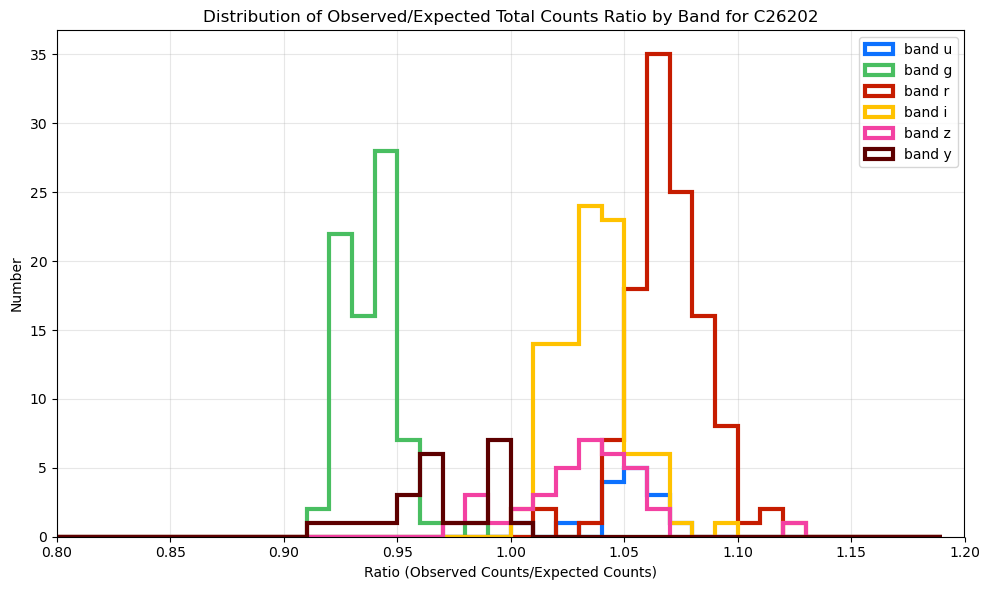

In [49]:
# Based on code retrieved from Claude-3.5-Sonnet and Poe.com Assistant

# Set up the plot
plt.figure(figsize=(10, 6))

# Define colors and transparency for each band
colors = plot_filter_colors_white_background
alpha = 1.0   # transparency level
linewidth = 3 # linewidth for the step histogram lines 

# Define bins.  Here, we want to look around ratio=1.00+/-0.20 in steps of 0.01
bins = np.arange(0.80, 1.20, 0.01)

# Plot histogram for each band
for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    band_data = best_df[best_df['band'] == band]['ratio_obs_exp']
    if len(band_data) > 0:  # only plot if we have data for this band
        plt.hist(band_data, bins=bins, alpha=alpha, histtype='step', linewidth=linewidth, 
                label=f'band {band}', color=colors[band],
                density=False)  # density=True normalizes the area

plt.xlabel('Ratio (Observed Counts/Expected Counts)')
plt.ylabel('Number')
plt.xlim([0.80, 1.20])
plt.title('Distribution of Observed/Expected Total Counts Ratio by Band for C26202')
plt.legend()
plt.grid(True, alpha=0.3)

# Optional: adjust layout to prevent label clipping
plt.tight_layout()

plt.show()



### 7.3 Print summary statistics for each band

In [50]:
# Based on code retrieved from Claude-3.5-Sonnet

for band in ['u', 'g', 'r', 'i', 'z', 'y']:
    band_data = best_df[best_df['band'] == band]['ratio_obs_exp']
    if len(band_data) > 0:
        print(f"\nBand {band} statistics:")
        print(f"N = {len(band_data)}")
        print(f"Mean = {band_data.mean():.3f}")
        print(f"Median = {band_data.median():.3f}")
        print(f"Std = {band_data.std():.3f}")


Band u statistics:
N = 30
Mean = 1.156
Median = 1.072
Std = 0.167

Band g statistics:
N = 77
Mean = 0.938
Median = 0.939
Std = 0.012

Band r statistics:
N = 115
Mean = 1.069
Median = 1.068
Std = 0.016

Band i statistics:
N = 92
Mean = 1.038
Median = 1.037
Std = 0.018

Band z statistics:
N = 36
Mean = 1.032
Median = 1.037
Std = 0.029

Band y statistics:
N = 23
Mean = 0.969
Median = 0.967
Std = 0.024


**Let's stop here for now:**

In [51]:
raise StopExecution

## 7. Sandbox

In [ ]:
# Check header of an ISR-corrected exposure image
icExp = butler.get('icExp', dataId=dataId)
icExp_info = icExp.getInfo()
print(icExp_info.getMetadata())
print(dataId)

In [ ]:
# From Lynne Jones...

# Read the file 
seddata = fits.getdata(sedfile)
# Translate to rubin_sim format
wavelen = seddata['WAVELENGTH'] * u.angstrom.to(u.nanometer) # This is in angstroms - need in nanometers
flambda = seddata['FLUX'] / (u.angstrom.to(u.nanometer)) # this is in erg/sec/cm^^2/ang but we want /nm 

defaultDirs = st.setDefaultDirs()
defaultDirs['detector'] = defaultDirs['detector'].replace('/joint_minimum', '/itl')
hardware, system = st.buildHardwareAndSystem(defaultDirs)

sed = pt.Sed(wavelen=wavelen, flambda=flambda)


# exposure time and gain -- gain=1 -> e- counts
phot_params = pt.PhotometricParameters(exptime=30, gain=1, nexp=1)

mags = {}
counts = {}
counts_100k = {}
for f in 'ugrizy':
    mags[f] = sed.calc_mag(system[f])
    counts[f] = sed.calc_adu(system[f], phot_params)
    counts_100k[f] = counts[f]/100000

#pd.DataFrame([mags, counts, counts_100k], index=['AB mag', 'total counts', 'counts(100k)'])
for f in 'ugrizy':
    print(f, mags[f], counts[f], counts_100k[f])

In [ ]:
fgcm_stars = butler.get("fgcm_Cycle5_StandardStars", collections=["u/erykoff/LSSTComCam/DM-47919/highlat/build4/run3"]).asAstropy()

In [ ]:
fgcm_stars

In [ ]:
fgcm_stars.write('fgcm_stars.ecsv')

In [ ]:
from astropy.table import Table
df_bad_visits=Table.read("https://raw.githubusercontent.com/lsst-dm/excluded_visits/refs/heads/main/LSSTComCam/bad.ecsv").to_pandas()
df_bad_visits.rename(columns={'exposure': 'visit'}, inplace=True)

In [ ]:
df_bad_visits